![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)

# <h1><center>Model Editing  <a href="https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/mjspec.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

This notebook provides an introductory tutorial for model editing in MuJoCo using the `mjSpec` API. This notebook assumes that the reader is already familiar with MuJoCo basic concepts, as demostrated in the [introductory tutorial](https://github.com/google-deepmind/mujoco?tab=readme-ov-file#getting-started). Documentation for this API can be found in the [Model Editing](https://mujoco.readthedocs.io/en/latest/programming/modeledit.html) chapter in the documentation (C API) and in the [Python chapter](https://mujoco.readthedocs.io/en/latest/python.html#model-editing). Here we use the Python API.

The goal of the API is to allow users to easily interact with and modify MuJoCo
models in Python, similarly to what the JavaScript DOM does for HTML.

<!-- Copyright 2024 DeepMind Technologies Limited

     Licensed under the Apache License, Version 2.0 (the "License");
     you may not use this file except in compliance with the License.
     You may obtain a copy of the License at

         http://www.apache.org/licenses/LICENSE-2.0

     Unless required by applicable law or agreed to in writing, software
     distributed under the License is distributed on an "AS IS" BASIS,
     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
     See the License for the specific language governing permissions and
     limitations under the License.
-->


## All imports

In [5]:
#!pip install mujoco

# Set up GPU rendering.
#from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco as mj
  mj.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

# Get MuJoCo's humanoid model and a Franka arm from the MuJoCo Menagerie.
print('Getting MuJoCo humanoid XML description from GitHub:')
!git clone https://github.com/google-deepmind/mujoco
humanoid_file = 'mujoco/model/humanoid/humanoid.xml'
humanoid100_file = 'mujoco/model/humanoid/humanoid100.xml'
print('Getting MuJoCo Menagerie Franka XML description from GitHub:')
!git clone https://github.com/google-deepmind/mujoco_menagerie
franka_file = 'mujoco_menagerie/franka_fr3/fr3.xml'

def render(model, data=None, height=250):
  if data is None:
    data = mj.MjData(model)
  with mj.Renderer(model, 480, 640) as renderer:
    mj.mj_forward(model, data)
    renderer.update_scene(data)
    media.show_image(renderer.render(), height=height)

FileNotFoundError: [Errno 2] No such file or directory: 'nvidia-smi'

In [ ]:
import mediapy as media
import matplotlib.pyplot as plt
import mujoco as mj
#import mujoco.Mjspec 
def render(model, data=None, height=250):
  if data is None:
    data = mj.MjData(model)
  with mj.Renderer(model, 480, 640) as renderer:
    mj.mj_forward(model, data)
    renderer.update_scene(data)
    media.show_image(renderer.render(), height=height)


OSError: ./ik_controller_cma/build2/libsolve_ik.so: cannot open shared object file: No such file or directory

# Parsing XML to `mjSpec` and compiling to `mjModel`


Unlike `mj_loadXML` which combines parsing and compiling, when using `mjSpec`, parsing and compiling are separate, allowing for editing steps:

""

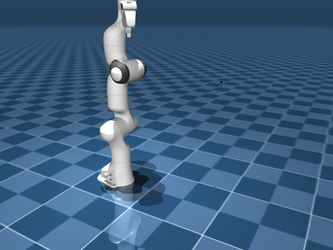

""

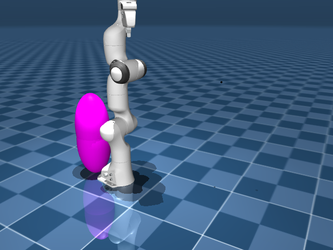

In [2]:
#@title A static model, from string {vertical-output: true}

static_model = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
#file_path = '/home/aniri/MuJoCo-Tutorial/xml/franka_test.xml'
file_path = "/home/aniri/nonlinear_obstacle_avoidance/franka_gym_test/envs2/franka_emika_panda/scene2.xml"
#spec = mj.MjSpec.from_string(static_model)
spec = mj.MjSpec.from_file(file_path)
#spec = mj.
#spec = mj.MjSpecify.from_string(static_model)
model = spec.compile()
render(model)

# Change the mjSpec, re-compile and re-render
# geoms = spec.worldbody.find_all(mj.mjtObj.mjOBJ_GEOM)
# geoms[0].name = 'blue_box'
# geoms[0].rgba = [0, 0, 1, 1]
# geoms[1].name = 'yellow_sphere'
# geoms[1].rgba = [1, 1, 0, 1]
spec.worldbody.add_geom(name='obstacle',
                        type=mj.mjtGeom.mjGEOM_ELLIPSOID,
                        rgba=[1, 0, 1, 1],
                        pos=[-.2, 0, .2],
                        size=[.1, .1, .2],
                        quat=[0, 0, 0, 1])
spec.worldbody.add_geom(name='obstacle2',
                        type=mj.mjtGeom.mjGEOM_ELLIPSOID,
                        rgba=[1, 0, 1, 1],
                        pos=[-.2, 0, .3],
                        size=[.1, .1, .2],
                        quat=[0, 0, 0, 1])

model = spec.compile()
render(model)

`mjSpec` can save XML to string, saving all modifications.

In [13]:
#@title Print an XML from an `mjSpec` {vertical-output: true}

print(spec.to_xml())

<mujoco model="panda scene">
  <compiler angle="radian" meshdir="assets/"/>

  <option integrator="implicitfast"/>

  <size nkey="1"/>

  <visual>
    <global azimuth="120" elevation="-20"/>
    <headlight ambient="0.3 0.3 0.3" diffuse="0.6 0.6 0.6" specular="0 0 0"/>
    <rgba haze="0.15 0.25 0.35 1"/>
  </visual>

  <statistic extent="1" center="0.3 0 0.4"/>

  <default>
    <default class="panda">
      <material shininess="0.25"/>
      <joint range="-2.8973 2.8973" armature="0.1" damping="1"/>
      <general ctrlrange="-2.8973 2.8973" forcerange="-87 87" biastype="affine"/>
      <default class="finger">
        <joint type="slide" range="0 0.04"/>
      </default>
      <default class="visual">
        <geom type="mesh" contype="0" conaffinity="0" group="2"/>
      </default>
      <default class="collision">
        <geom type="mesh" group="3"/>
        <default class="fingertip_pad_collision_1">
          <geom size="0.0085 0.004 0.0085" type="box"/>
        </default>
        

In [6]:
#@title Building an `mjSpec` from scratch {vertical-output: true}

spec = mj.MjSpec()
spec.worldbody.add_light(name="top", pos=[0, 0, 1])
body = spec.worldbody.add_body(name="box_and_sphere", euler=[0, 0, -30])
body.add_joint(name="swing", type=mj.mjtJoint.mjJNT_HINGE,
               axis=[1, -1, 0], pos=[-.2, -.2, -.2])
body.add_geom(name="red_box", type=mj.mjtGeom.mjGEOM_BOX,
              size=[.2, .2, .2], rgba=[1, 0, 0, 1])
body.add_geom(name="green_sphere", pos=[.2, .2, .2],
              size=[.1, 0, 0], rgba=[0, 1, 0, 1])
model = spec.compile()

duration = 2    # (seconds)
framerate = 30  # (Hz)

# enable joint visualization option:
scene_option = mj.MjvOption()
scene_option.flags[mj.mjtVisFlag.mjVIS_JOINT] = True

# Simulate and display video.
frames = []
data = mj.MjData(model)
mj.mj_resetData(model, data)
with mj.Renderer(model) as renderer:
  while data.time < duration:
    mj.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data, scene_option=scene_option)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)


# Control example

A key feature of this library is the ability to easily attach multiple models into a larger one. Disambiguation of duplicated names from different
models, or multiple instances of the same model, is handled via user-defined namespacing.

One example use case is when we want robots with a variable number of joints, as is a fundamental change to the kinematic structure. The following snippets realise this scenario.

In [7]:
leg_model = """
<mujoco>
  <compiler angle="radian"/>

  <default>
    <joint damping="2" type="hinge"/>
    <geom type="capsule"/>
  </default>

  <worldbody>
    <body name="thigh">
      <joint name="hip" axis="0 0 1"/>
      <body name="shin">
        <joint name="knee" axis="0 1 0"/>
      </body>
    </body>
  </worldbody>

  <actuator>
    <position joint="hip" kp="10"/>
    <position joint="knee" kp="10"/>
  </actuator>
</mujoco>
"""

class Leg(object):
  """A 2-DoF leg with position actuators."""
  def __init__(self, length, rgba):
    self.spec = mj.MjSpec.from_string(leg_model)

    # Thigh:
    thigh = self.spec.find_body('thigh')
    thigh.add_geom(fromto=[0, 0, 0, length, 0, 0], size=[length/4, 0, 0], rgba=rgba)

    # Hip:
    shin = self.spec.find_body('shin')
    shin.add_geom(fromto=[0, 0, 0, 0, 0, -length], size=[length/5, 0, 0], rgba=rgba)
    shin.pos[0] = length

The `Leg` class describes an abstract articulated leg, with two joints and corresponding proportional-derivative actuators.

Note that:

- MJCF attributes correspond directly to arguments of the `add_()` methods.
- When referencing elements, e.g when specifying the joint to which an actuator is attached, the name string of the MJCF elements is used.

In [9]:
import numpy as np
BODY_RADIUS = 0.1
random_state = np.random.RandomState(42)
creature_model = """
<mujoco>
  <compiler angle="radian"/>

  <worldbody>
    <geom name="torso" type="ellipsoid" size="{} {} {}"/>
  </worldbody>
</mujoco>
""".format(BODY_RADIUS, BODY_RADIUS, BODY_RADIUS / 2)

def make_creature(num_legs):
  """Constructs a creature with `num_legs` legs."""
  rgba = random_state.uniform([0, 0, 0, 1], [1, 1, 1, 1])
  spec = mj.MjSpec.from_string(creature_model)

  # Attach legs to equidistant sites on the circumference.
  spec.worldbody.first_geom().rgba = rgba
  leg = Leg(length=BODY_RADIUS, rgba=rgba)
  for i in range(num_legs):
    theta = 2 * i * np.pi / num_legs
    hip_pos = BODY_RADIUS * np.array([np.cos(theta), np.sin(theta), 0])
    hip_site = spec.worldbody.add_site(pos=hip_pos, euler=[0, 0, theta])
    hip_site.attach(leg.spec.find_body('thigh'), '', '-' + str(i))

  return spec

The `make_creature` function uses the `attach()` method to procedurally attach legs to the torso. Note that at this stage both the torso and hip attachment sites are children of the `worldbody`, since their parent body has yet to be instantiated. We'll now make an arena with a chequered floor and two lights, and place our creatures in a grid.

""

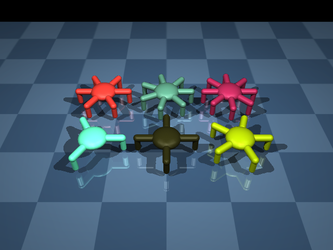

In [10]:
#@title Six Creatures on a floor.{vertical-output: true}

arena = mj.MjSpec()

if hasattr(arena, 'compiler'):
  arena.compiler.degree = False  # MuJoCo dev (next release).
else:
  arena.degree = False  # MuJoCo release

# Make arena with textured floor.
chequered = arena.add_texture(
    name="chequered", type=mj.mjtTexture.mjTEXTURE_2D,
    builtin=mj.mjtBuiltin.mjBUILTIN_CHECKER,
    width=300, height=300, rgb1=[.2, .3, .4], rgb2=[.3, .4, .5])
grid = arena.add_material(
    name='grid', texrepeat=[5, 5], reflectance=.2
    ).textures[mj.mjtTextureRole.mjTEXROLE_RGB] = 'chequered'
arena.worldbody.add_geom(
    type=mj.mjtGeom.mjGEOM_PLANE, size=[2, 2, .1], material='grid')
for x in [-2, 2]:
  arena.worldbody.add_light(pos=[x, -1, 3], dir=[-x, 1, -2])

# Instantiate 6 creatures with 3 to 8 legs.
creatures = [make_creature(num_legs=num_legs) for num_legs in range(3, 9)]

# Place them on a grid in the arena.
height = .15
grid = 5 * BODY_RADIUS
xpos, ypos, zpos = np.meshgrid([-grid, 0, grid], [0, grid], [height])
for i, spec in enumerate(creatures):
  # Place spawn sites on a grid.
  spawn_pos = (xpos.flat[i], ypos.flat[i], zpos.flat[i])
  spawn_site = arena.worldbody.add_site(pos=spawn_pos, group=3)
  # Attach to the arena at the spawn sites, with a free joint.
  spawn_body = spawn_site.attach(spec.worldbody, '', '-' + str(i))
  spawn_body.add_freejoint()

# Instantiate the physics and render.
model = arena.compile()
render(model)

Multi-legged creatures, ready to roam! Let's inject some controls and watch them move. We'll generate a sinusoidal open-loop control signal of fixed frequency and random phase, recording both video frames and the horizontal positions of the torso geoms, in order to plot the movement trajectories.

In [11]:
#@title Video of the movement{vertical-output: true}

duration = 10   # (Seconds)
framerate = 30  # (Hz)
video = []
pos_x = []
pos_y = []
geoms = arena.worldbody.find_all(mj.mjtObj.mjOBJ_GEOM)
torsos = [geom.id for geom in geoms if 'torso' in geom.name]
actuators = [actuator.id for actuator in arena.actuators]

# Control signal frequency, phase, amplitude.
freq = 5
phase = 2 * np.pi * random_state.rand(len(arena.actuators))
amp = 0.9

# Simulate, saving video frames and torso locations.
data = mj.MjData(model)
mj.mj_resetData(model, data)
with mj.Renderer(model) as renderer:
  while data.time < duration:
    # Inject controls and step the physics.
    data.ctrl[actuators] = amp * np.sin(freq * data.time + phase)
    mj.mj_step(model, data)

    # Save torso horizontal positions using name indexing.
    pos_x.append(data.geom_xpos[torsos, 0].copy())
    pos_y.append(data.geom_xpos[torsos, 1].copy())

    # Save video frames.
    if len(video) < data.time * framerate:
      renderer.update_scene(data)
      pixels = renderer.render()
      video.append(pixels.copy())

media.show_video(video, fps=framerate)

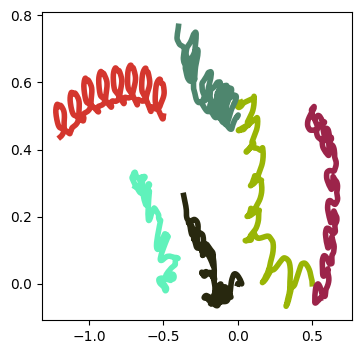

In [12]:
#@title Movement trajectories{vertical-output: true}

creature_colors = model.geom_rgba[torsos][:, :3]
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_prop_cycle(color=creature_colors)
_ = ax.plot(pos_x, pos_y, linewidth=4)

The plot above shows the corresponding movement trajectories of creature positions. Note how `mjSpec` attribute `id` were used to access both `xpos` and `rgba` values. This attribute is valid only after a model is compiled.

# Model editing

`mjSpec` elements can be traversed in two ways:
- For elements inside the kinematic tree, the tree can be traversed using the `first` and `next` functions.
- For all other elements, we provide a list.



In [13]:
#@title Traversing the spec.{vertical-output: true}

spec = mj.MjSpec.from_file(humanoid_file)

# Function that recursively prints all body names
def print_bodies(parent, level=0):
  body = parent.first_body()
  while body:
    print(''.join(['-' for i in range(level)]) + body.name)
    print_bodies(body, level + 1)
    body = parent.next_body(body)

print("The spec has the following actuators:")
for actuator in spec.actuators:
  print(actuator.name)

print("\nThe spec has the following bodies:")
print_bodies(spec.worldbody)

NameError: name 'humanoid_file' is not defined

An `mjSpec` can be compiled multiple times. If the state has to be preserved between different compilations, then the function `recompile()` must be used, which returns a new `mjData` that contains the mapped state, possibly having a different dimension from the origin.

In [ ]:
#@title Model re-compilation with state preservation.{vertical-output: true}

spec = mj.MjSpec.from_file(humanoid100_file)
model = spec.compile()
data = mj.MjData(model)

# Run for 5 seconds
for i in range(1000):
  mj.mj_step(model, data)

# Show result
render(model, data)

# Create list of all bodies we want to delete
body = spec.worldbody.first_body()
delete_list = []
while body:
  geom_type = body.first_geom().type
  if (geom_type == mj.mjtGeom.mjGEOM_BOX or
      geom_type == mj.mjtGeom.mjGEOM_ELLIPSOID):
    delete_list.append(body)
  body = spec.worldbody.next_body(body)

# Remove all bodies in the list from the spec
for body in delete_list:
  spec.detach_body(body)

# # Add another humanoid
spec_humanoid = mj.MjSpec.from_file(humanoid_file)
attachment_frame = spec.worldbody.add_frame(pos=[0, -1, 2])
attachment_frame.attach_body(spec_humanoid.find_body('torso'), 'a', 'b')

# Recompile preserving the state
new_model, new_data = spec.recompile(model, data)

# Show result
render(new_model, new_data)

Let us load the humanoid model and inspect it.

In [ ]:
#@title Humanoid model.{vertical-output: true}

spec = mj.MjSpec.from_file(humanoid_file)

model = spec.compile()
render(model)

We wish to remove the arms and replace them with the legs. This can be done by first storing the arm positions into frames attaches to the torso. Then we can detach the arms and self-attach the legs into the frames.

In [ ]:
#@title Humanoid with arms replaced by legs.{vertical-output: true}

spec = mj.MjSpec.from_file(humanoid_file)

# Get the torso, arm, and leg bodies
arm_left = spec.find_body('upper_arm_left')
arm_right = spec.find_body('upper_arm_right')
leg_left = spec.find_body('thigh_left')
leg_right = spec.find_body('thigh_right')
torso = spec.find_body('torso')

# Attach frames at the arm positions
shoulder_left = torso.add_frame(pos=arm_left.pos)
shoulder_right = torso.add_frame(pos=arm_right.pos)

# Remove the arms
spec.detach_body(arm_left)
spec.detach_body(arm_right)

# Add new legs
shoulder_left.attach_body(leg_left, 'shoulder', 'left')
shoulder_right.attach_body(leg_right, 'shoulder', 'right')

model = spec.compile()
render(model, height=400)

Similarly, different models can be attach together. Here, the right arm is detached and a robot arm from a different model is attached in its place.

In [ ]:
#@title Humanoid with Franka arm.{vertical-output: true}

spec = mj.MjSpec.from_file(humanoid_file)
franka = mj.MjSpec.from_file(franka_file)

if hasattr(spec, 'compiler'):
  spec.compiler.degree = False  # MuJoCo dev (next release).
else:
  spec.degree = False  # MuJoCo release

# Replace right arm with frame
arm_right = spec.find_body('upper_arm_right')
torso = spec.find_body('torso')
shoulder_right = torso.add_frame(pos=arm_right.pos, quat=[0, 0.8509035, 0, 0.525322])
spec.detach_body(arm_right)

# Attach Franka arm to humanoid
franka_arm = franka.find_body('fr3_link2')
shoulder_right.attach_body(franka_arm, 'franka', '')

model = spec.compile()
render(model, height=400)

When doing this, the actuators and all other objects referenced by the attached sub-tree are imported in the new model. All assets are currently imported, referenced or not.

In [ ]:
#@title Imported actuators.{vertical-output: true}

for actuator in spec.actuators:
  print(actuator.name)

Domain randomization can be performed by attaching multiple times the same spec, edited each time with a new instance of randomized parameters.

In [ ]:
#@title Humanoid with randomized heads and arm poses.{vertical-output: true}

humanoid = mj.MjSpec.from_file(humanoid_file)
spec = mj.MjSpec()

# Delete all key frames to avoid name conflicts
while humanoid.keys:
  humanoid.keys[-1].delete()

# Create a grid of humanoids by attaching humanoid to spec multiple times
for i in range(4):
  for j in range(4):
    humanoid.materials[0].rgba = [
        np.random.uniform(), np.random.uniform(),
        np.random.uniform(), 1]  # Randomize color
    humanoid.find_body('head').first_geom().size = [
        .18*np.random.uniform(), 0, 0]  # Randomize head size
    humanoid.find_body('upper_arm_left').quat = [
        np.random.uniform(), np.random.uniform(),
        np.random.uniform(), np.random.uniform()]  # Randomize left arm orientation
    humanoid.find_body('upper_arm_right').quat = [
        np.random.uniform(), np.random.uniform(),
        np.random.uniform(), np.random.uniform()]  # Randomize right arm orientation

    # attach randomized humanoid to parent spec
    frame = spec.worldbody.add_frame(pos=[i, j, 0])
    frame.attach_body(humanoid.find_body('torso'), str(i), str(j))

spec.worldbody.add_light(mode=mj.mjtCamLight.mjCAMLIGHT_TARGETBODYCOM,
                         targetbody='3torso3', diffuse=[.8, .8, .8],
                         specular=[0.3, 0.3, 0.3], pos=[0, -6, 4], cutoff=30)
model = spec.compile()
render(model, height=400)